### WavLM-TDNN Baseline Inference with Cosine Similarity (Testing Process)

In [21]:
import os
import os.path as osp
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F

from core import evaluation

from my_datasets.osid_dataloader_spk import SpeakerDataloader


# Assuming you have a directory path that contains subdirectories for each speaker
# and each subdirectory has `.npy` files for utterances.
# dir_path = 'path_to_embeddings'

def load_and_average_embeddings(dir_path, num_speakers=5, num_utterances=40):
    mat_enrolled = torch.zeros(num_speakers, 512)  # Assuming embeddings are of size 512
    for spk_id in range(num_speakers):
        spk_embeddings = []
        for utt_id in range(num_utterances):
            file_path = os.path.join(dir_path, str(spk_id), f"{utt_id}.npy")
            embedding = torch.load(file_path)
            embedding_tensor = torch.from_numpy(embedding)
            spk_embeddings.append(embedding_tensor)
        # Convert list of tensors to a tensor, then compute mean along the 0th dimension
        spk_embeddings_tensor = torch.stack(spk_embeddings)
        mat_enrolled[spk_id] = torch.mean(spk_embeddings_tensor, dim=0)
    return mat_enrolled

def CosineSimModeling(testloader, outloader, dir_path, use_gpu=True):
    correct, total = 0, 0
    _pred_k, _pred_u, _labels = [], [], []
    _pred_emb,_pred_emb_u = [], []

    # Load and average embeddings to create mat_enrolled
    mat_enrolled = load_and_average_embeddings(dir_path)
    mat_enrolled = torch.tensor(mat_enrolled).float()
    if use_gpu:
        mat_enrolled = mat_enrolled.cuda()

    with torch.no_grad():
        for data, labels in testloader:
            if use_gpu:
                data, labels = data.cuda(), labels.cuda()
            
            # Calculate cosine similarity
            logits = F.cosine_similarity(data.unsqueeze(1), mat_enrolled.unsqueeze(0), dim=2)

            predictions = logits.data.max(1)[1]
            total += labels.size(0)
            correct += (predictions == labels.data).sum()

            _pred_k.append(logits.data.cpu().numpy())
            _labels.append(labels.data.cpu().numpy())
            _pred_emb.append(data.data.cpu().numpy())

        for batch_idx, (data, labels) in enumerate(outloader):
            if use_gpu:
                data, labels = data.cuda(), labels.cuda()

            logits = F.cosine_similarity(data.unsqueeze(1), mat_enrolled.unsqueeze(0), dim=2)

            _pred_u.append(logits.data.cpu().numpy())
            _pred_emb_u.append(data.data.cpu().numpy())

    acc = float(correct) * 100. / float(total)
    print('Acc: {:.5f}'.format(acc))

    _pred_k = np.concatenate(_pred_k, 0)
    _pred_u = np.concatenate(_pred_u, 0)
    _labels = np.concatenate(_labels, 0)
    
    # Out-of-Distribution detction evaluation
    x1, x2 = np.max(_pred_k, axis=1), np.max(_pred_u, axis=1)
    results = evaluation.metric_ood(x1, x2)['Bas']
    
    # OSCR
    _oscr_socre = evaluation.compute_oscr(_pred_k, _pred_u, _labels)

    results['ACC'] = acc
    results['OSCR'] = _oscr_socre * 100.

    return results, _pred_emb, _labels, _pred_emb_u


In [22]:
Data = SpeakerDataloader(known=[0, 1, 2, 3, 4], test_root='./QSpeech_wavLMTDNN_embs/emb_test', batch_size=64)
testloader, outloader = Data.test_loader, Data.out_loader

results, _pred_emb, _labels, _pred_emb_u = CosineSimModeling(testloader, outloader, '/nvme/zhiyong/Q/sidemb_train', use_gpu=True)
print("Acc (%): {:.3f}\t AUROC (%): {:.3f}\t OSCR (%): {:.3f}\t".format(results['ACC'], results['AUROC'], results['OSCR']))

Test Known:  215 Test Unknown:  446


/tmp/ipykernel_26446/592783684.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat_enrolled = torch.tensor(mat_enrolled).float()


Acc: 99.53488
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    49.103 84.090 76.058 72.369 91.832
Acc (%): 99.535	 AUROC (%): 84.090	 OSCR (%): 83.611	


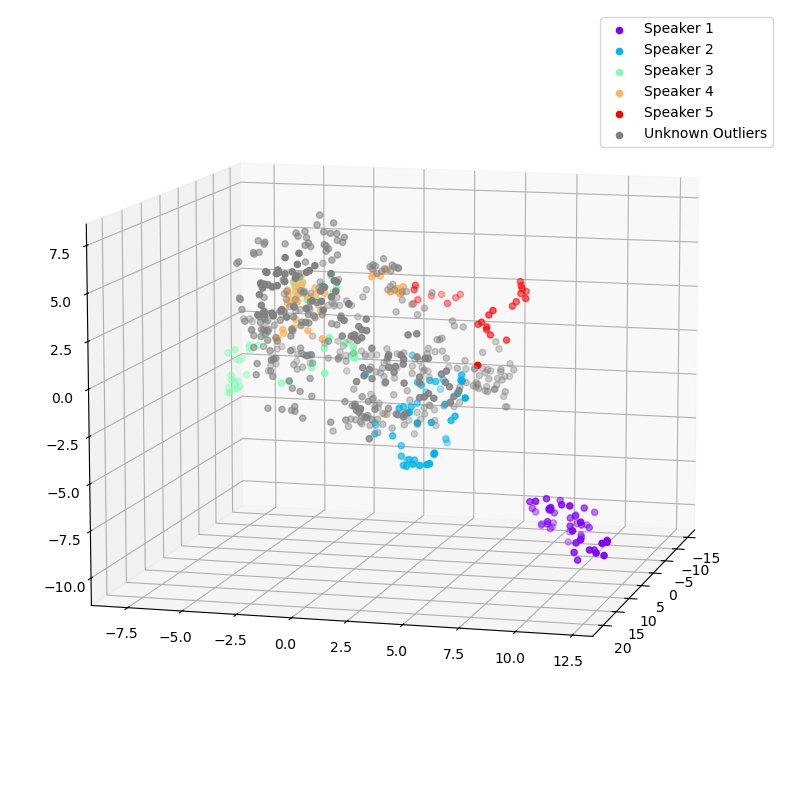

In [24]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit
import matplotlib.cm as cm

# Concatenate the arrays in _pred_emb
pred_emb = np.concatenate(_pred_emb, axis=0)

# Concatenate the arrays in _pred_emb_u
pred_emb_u = np.concatenate(_pred_emb_u, axis=0)

# Concatenate known and outlier embeddings
combined_embeddings = np.concatenate((pred_emb, pred_emb_u), axis=0)

# Apply t-SNE reduction to 3 dimensions
tsne = TSNE(n_components=3, random_state=42)
reduced_embeddings = tsne.fit_transform(combined_embeddings)

# Split the reduced embeddings back into known and outlier sets
reduced_pred_emb = reduced_embeddings[:len(pred_emb)]
reduced_pred_emb_u = reduced_embeddings[len(pred_emb):]

# Plotting in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Plot known speaker embeddings with labels
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(_labels))))
for i, color in zip(np.unique(_labels), colors):
    ax.scatter(reduced_pred_emb[_labels == i, 0], reduced_pred_emb[_labels == i, 1], reduced_pred_emb[_labels == i, 2], c=[color], label=f"Speaker {i+1}")

# Plot 'outlier' speaker embeddings in grey
ax.scatter(reduced_pred_emb_u[:, 0], reduced_pred_emb_u[:, 1], reduced_pred_emb_u[:, 2], c='grey', label='Unknown Outliers')

elevation_angle = 10  # Example elevation angle
azimuth_angle = 15   # Example azimuth angle
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

plt.legend()
plt.savefig('tsne_wavlm_n.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


### Rapid Tuning/Target Speaker Enrollment with SRPL (Testing Process)

In [1]:
import os
import argparse
import datetime
import time
import csv
import pandas as pd
import importlib

import torch
import torch.nn as nn

from models.models_adpt import classifier_spk
from my_datasets.osid_dataloader_spk import SpeakerDataloader
from utils import Logger, save_networks, load_networks
from core.test_srpl import eval_osid

In [2]:
# settings for SRPL+
options ={}
options['loss'] = 'SRPL'
options['use_gpu'] = True
options['feat_dim'] = 256 # TDNN speaker embedding dim
options['known'] = [0, 1, 2, 3, 4] # ID 0-5 as target speakers and others as outliers

# hyperparameters for SRPL lambdas
options['weight_pl'] = 5

In [15]:
model_path = os.path.join('./models_tmp')
file_name = '{}_{}'.format('ClassifierAdapt', 'SRPL')

In [10]:
Data = SpeakerDataloader(known=options['known'], test_root='./QSpeech_wavLMTDNN_embs/emb_test', batch_size=64)
testloader, outloader = Data.test_loader, Data.out_loader

Test Known:  215 Test Unknown:  446


In [11]:
net = classifier_spk()

In [12]:
Loss = importlib.import_module('loss.'+options['loss'])
criterion = getattr(Loss, 'ARPLoss')(**options)

In [13]:
if options['use_gpu']:
    net = nn.DataParallel(net).cuda()
    criterion = criterion.cuda()

In [17]:
net, criterion = load_networks(net, model_path, file_name, criterion=criterion)
results, _pred_emb, _labels, _pred_emb_u = eval_osid(net, criterion, testloader, outloader, epoch=0, **options)
print("Acc (%): {:.3f}\t AUROC (%): {:.3f}\t OSCR (%): {:.3f}\t".format(results['ACC'], results['AUROC'], results['OSCR']))

Acc: 97.20930
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    73.318 95.726 90.918 93.048 97.350
Acc (%): 97.209	 AUROC (%): 95.726	 OSCR (%): 94.251	


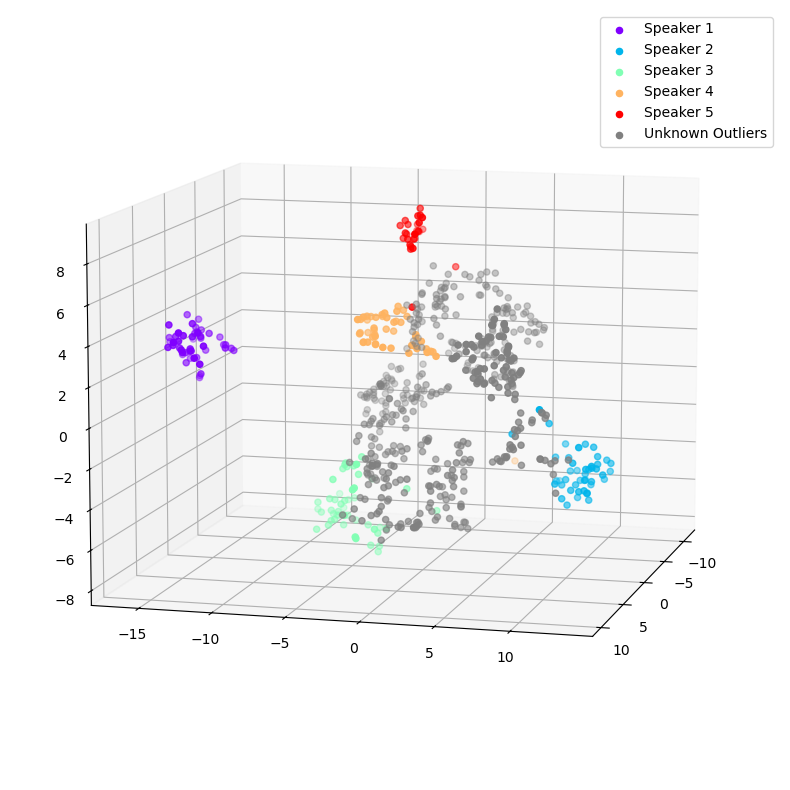

In [18]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit
import matplotlib.cm as cm


# Concatenate the arrays in _pred_emb
pred_emb = np.concatenate(_pred_emb, axis=0)

# Concatenate the arrays in _pred_emb_u
pred_emb_u = np.concatenate(_pred_emb_u, axis=0)

# Concatenate known and outlier embeddings
combined_embeddings = np.concatenate((pred_emb, pred_emb_u), axis=0)

# Apply t-SNE reduction to 3 dimensions
tsne = TSNE(n_components=3, random_state=42)
reduced_embeddings = tsne.fit_transform(combined_embeddings)

# Split the reduced embeddings back into known and outlier sets
reduced_pred_emb = reduced_embeddings[:len(pred_emb)]
reduced_pred_emb_u = reduced_embeddings[len(pred_emb):]

# Plotting in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Plot known speaker embeddings with labels
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(_labels))))
for i, color in zip(np.unique(_labels), colors):
    ax.scatter(reduced_pred_emb[_labels == i, 0], reduced_pred_emb[_labels == i, 1], reduced_pred_emb[_labels == i, 2], c=[color], label=f"Speaker {i+1}")

# Plot 'outlier' speaker embeddings in grey
ax.scatter(reduced_pred_emb_u[:, 0], reduced_pred_emb_u[:, 1], reduced_pred_emb_u[:, 2], c='grey', label='Unknown Outliers')

# Set the angle of view
elevation_angle = 10  # Example elevation angle
azimuth_angle = 15   # Example azimuth angle
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

plt.legend()
plt.savefig('tsne_srpl_ns_n.png', format='png', dpi=600, bbox_inches='tight')
plt.show()
